In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rishithnmula","key":"8e574ccddca2d85ad45ceab52d0d9233"}'}

In [3]:
#create a kaggle folder
!mkdir ~/.kaggle

In [4]:
#copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

In [6]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [01:45<00:00, 39.2MB/s]
100% 5.30G/5.30G [01:46<00:00, 53.7MB/s]


In [7]:
!unzip food41.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/tacos/1026681.jpg  
  inflating: images/tacos/1030289.jpg  
  inflating: images/tacos/1033196.jpg  
  inflating: images/tacos/1036030.jpg  
  inflating: images/tacos/1042175.jpg  
  inflating: images/tacos/1044043.jpg  
  inflating: images/tacos/1058697.jpg  
  inflating: images/tacos/1059239.jpg  
  inflating: images/tacos/1059326.jpg  
  inflating: images/tacos/1066762.jpg  
  inflating: images/tacos/1070967.jpg  
  inflating: images/tacos/1073468.jpg  
  inflating: images/tacos/1075296.jpg  
  inflating: images/tacos/1085243.jpg  
  inflating: images/tacos/108529.jpg  
  inflating: images/tacos/1086014.jpg  
  inflating: images/tacos/108945.jpg  
  inflating: images/tacos/1089575.jpg  
  inflating: images/tacos/1091159.jpg  
  inflating: images/tacos/1101369.jpg  
  inflating: images/tacos/1109058.jpg  
  inflating: images/tacos/1109744.jpg  
  inflating: images/tacos/1119371.jpg  
  inflating: images/tacos/11237

In [8]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [9]:
image_dir = Path('/content/images')

In [10]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
lables = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
lables = pd.Series(lables, name= 'Lable')

images = pd.concat([filepaths, lables], axis=1)

category_samples = []
for category in images['Lable'].unique():
  category_slice = images.query("Lable == @category")
  category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [11]:
image_df

,Filepath,Lable
0,/content/images/ramen/3520891.jpg,ramen
1,/content/images/spaghetti_carbonara/2008810.jpg,spaghetti_carbonara
2,/content/images/fish_and_chips/2249482.jpg,fish_and_chips
3,/content/images/donuts/1829368.jpg,donuts
4,/content/images/cheese_plate/909033.jpg,cheese_plate
...,...,...
10095,/content/images/pulled_pork_sandwich/221952.jpg,pulled_pork_sandwich
10096,/content/images/sushi/380314.jpg,sushi
10097,/content/images/omelette/3270955.jpg,omelette
10098,/content/images/tuna_tartare/2643219.jpg,tuna_tartare


In [12]:
image_df['Lable'].value_counts()

hot_dog               100
waffles               100
donuts                100
red_velvet_cake       100
chicken_quesadilla    100
                     ... 
deviled_eggs          100
tiramisu              100
panna_cotta           100
carrot_cake           100
edamame               100
Name: Lable, Length: 101, dtype: int64

Train-test *split*

In [13]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

creating generator

In [15]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [16]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Lable',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Lable',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Lable',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False

)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


#Modeling

In [17]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg' 
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [18]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

#Training

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
177/177 [==============================] - 215s 1s/step - loss: 3.8529 - accuracy: 0.1434 - val_loss: 2.9254 - val_accuracy: 0.2871
Epoch 2/100
177/177 [==============================] - 252s 1s/step - loss: 2.3650 - accuracy: 0.4040 - val_loss: 2.5137 - val_accuracy: 0.3925
Epoch 3/100
177/177 [==============================] - 211s 1s/step - loss: 1.7983 - accuracy: 0.5301 - val_loss: 2.4620 - val_accuracy: 0.3925
Epoch 4/100
177/177 [==============================] - 212s 1s/step - loss: 1.4226 - accuracy: 0.6169 - val_loss: 2.4015 - val_accuracy: 0.4293
Epoch 5/100
177/177 [==============================] - 214s 1s/step - loss: 1.1328 - accuracy: 0.6966 - val_loss: 2.4617 - val_accuracy: 0.4243
Epoch 6/100
177/177 [==============================] - 213s 1s/step - loss: 0.8725 - accuracy: 0.7679 - val_loss: 2.4813 - val_accuracy: 0.4364
Epoch 7/100
177/177 [==============================] - 211s 1s/step - loss: 0.6508 - accuracy: 0.8366 - val_loss: 2.5792 - val_accuracy:

#Classification results


In [20]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.62%


In [25]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

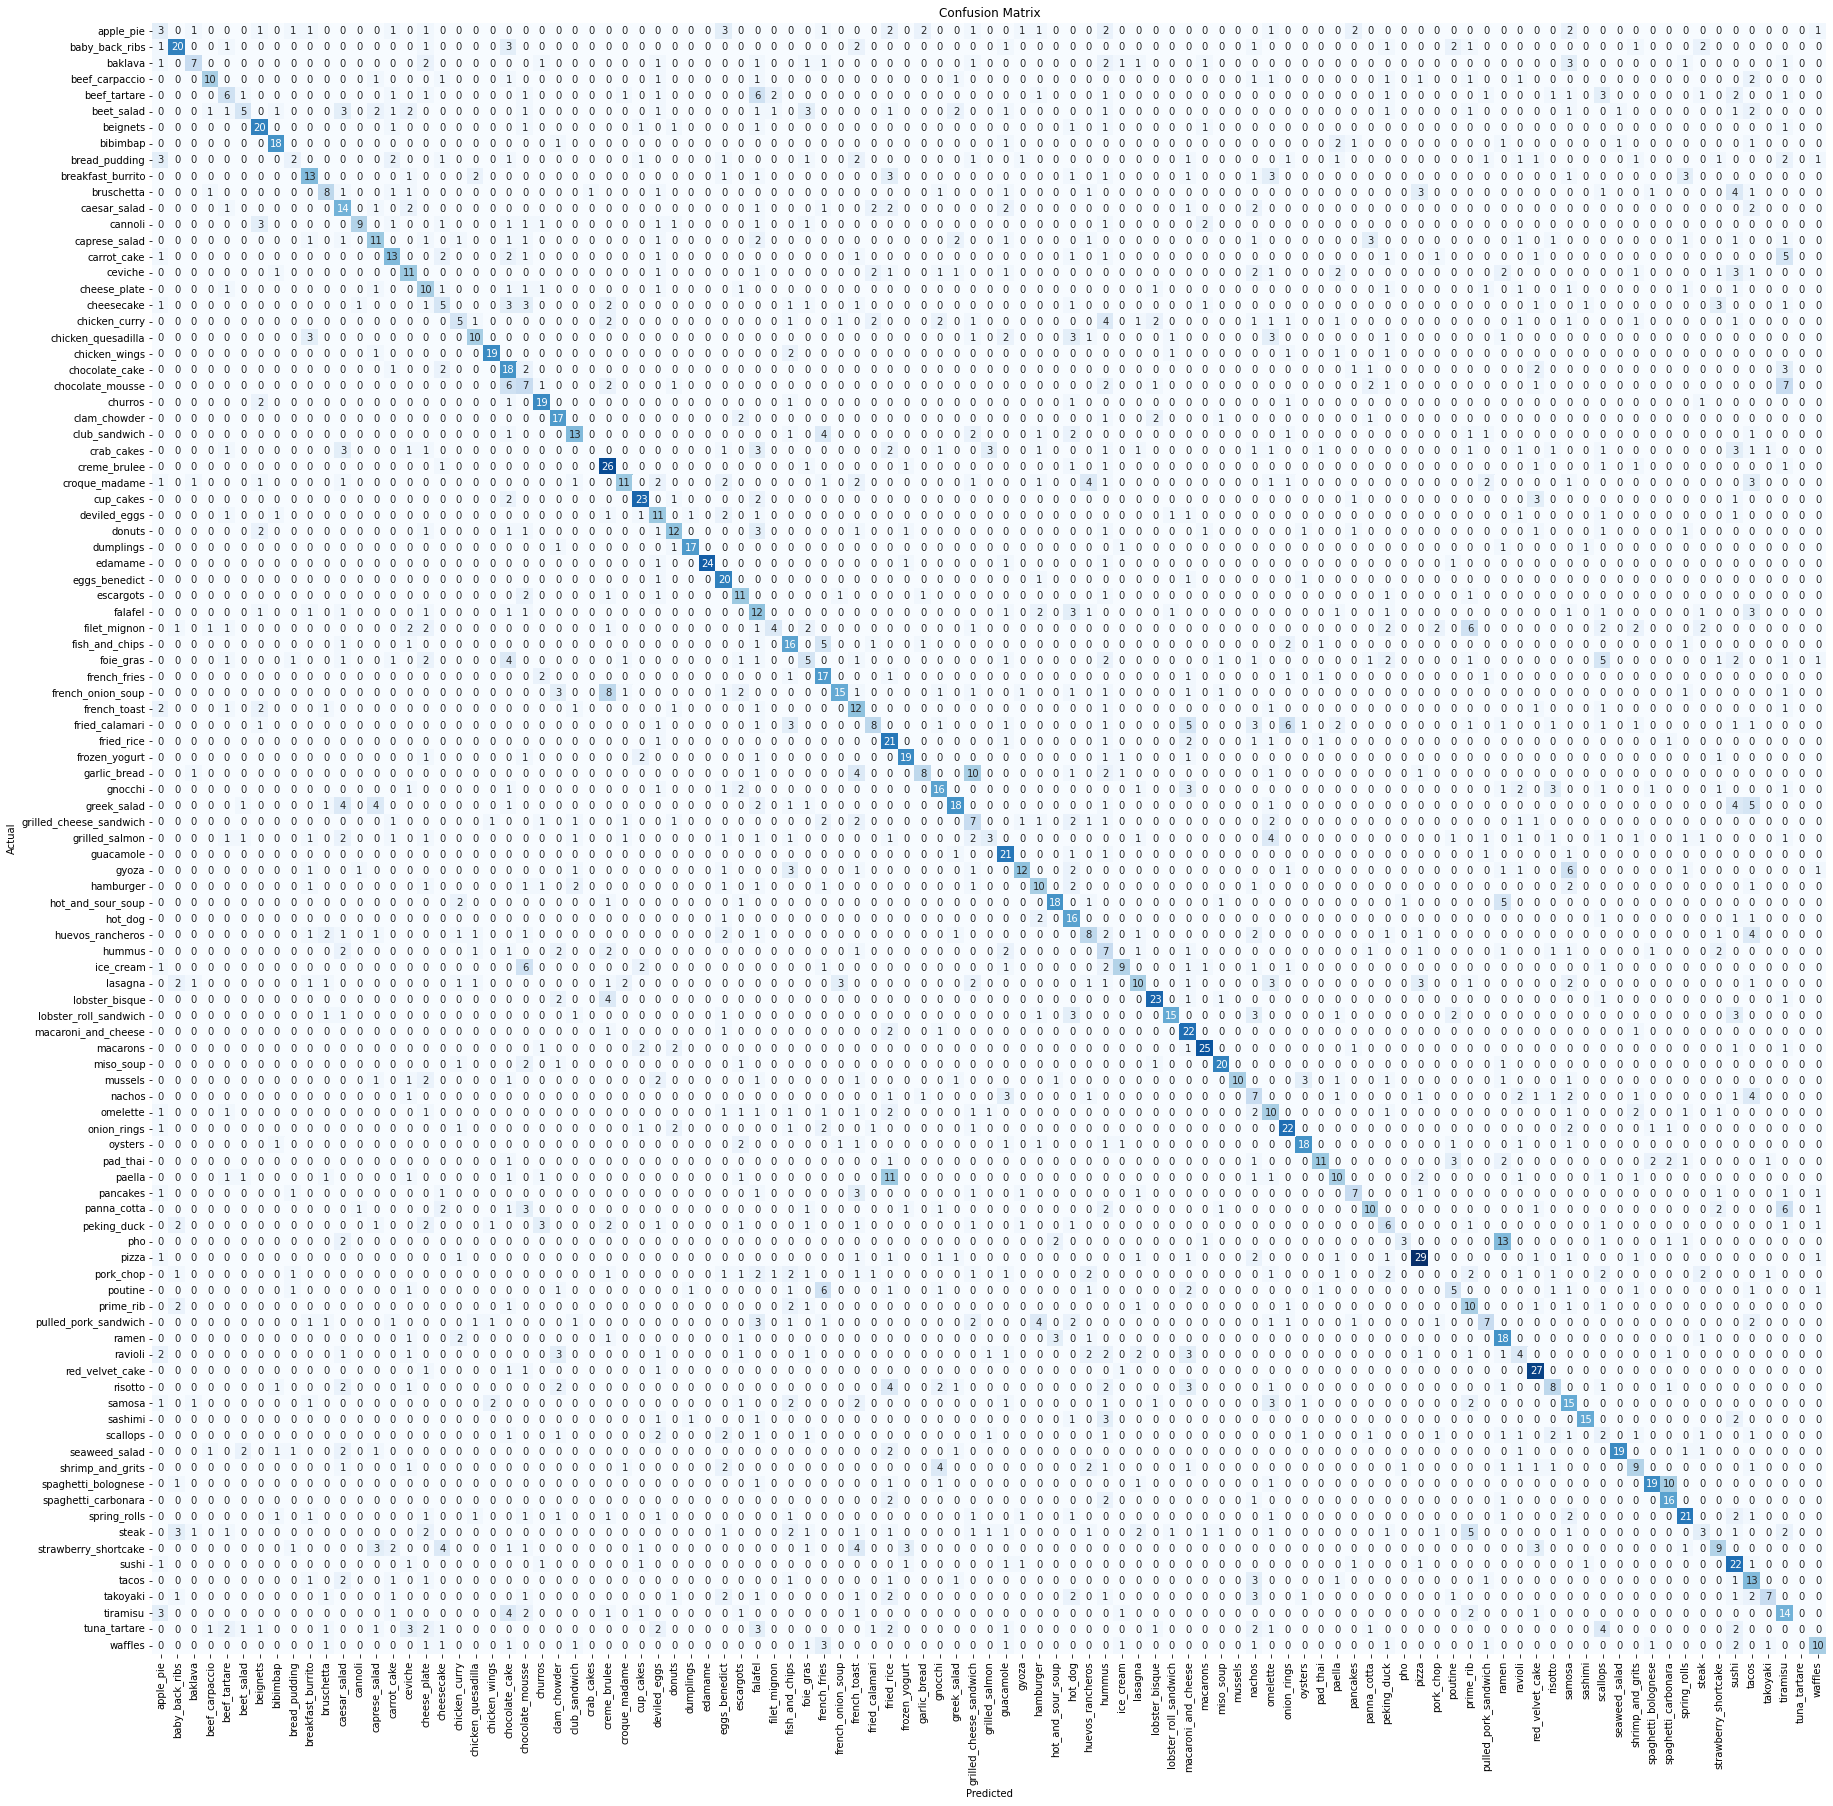

In [27]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, lables=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, lables=test_images.class_indices, rotation=0)
plt.xlable("Predicted")
plt.ylable("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
print("Classificatin Report:\n----------------------\n", clr)

Classificatin Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.12      0.11      0.11        28
         baby_back_ribs       0.61      0.54      0.57        37
                baklava       0.54      0.27      0.36        26
         beef_carpaccio       0.67      0.42      0.51        24
           beef_tartare       0.29      0.18      0.22        33
             beet_salad       0.42      0.14      0.21        35
               beignets       0.59      0.69      0.63        29
               bibimbap       0.72      0.69      0.71        26
          bread_pudding       0.22      0.07      0.11        27
      breakfast_burrito       0.46      0.41      0.43        32
             bruschetta       0.42      0.30      0.35        27
           caesar_salad       0.30      0.45      0.36        31
                cannoli       0.75      0.38      0.50        24
          caprese_salad       0.38      0.3

In [29]:
results = model.evaluate(train_images, verbose=0)
print("Train Accuracy: {:.2f}%".format(results[1] * 100))

Train Accuracy: 71.92%


In [30]:
predictions = np.argmax(model.predict(train_images), axis=1)

cm = confusion_matrix(train_images.labels, predictions)
clr = classification_report(train_images.labels, predictions, target_names=train_images.class_indices, zero_division=0)

AttributeError: ignored

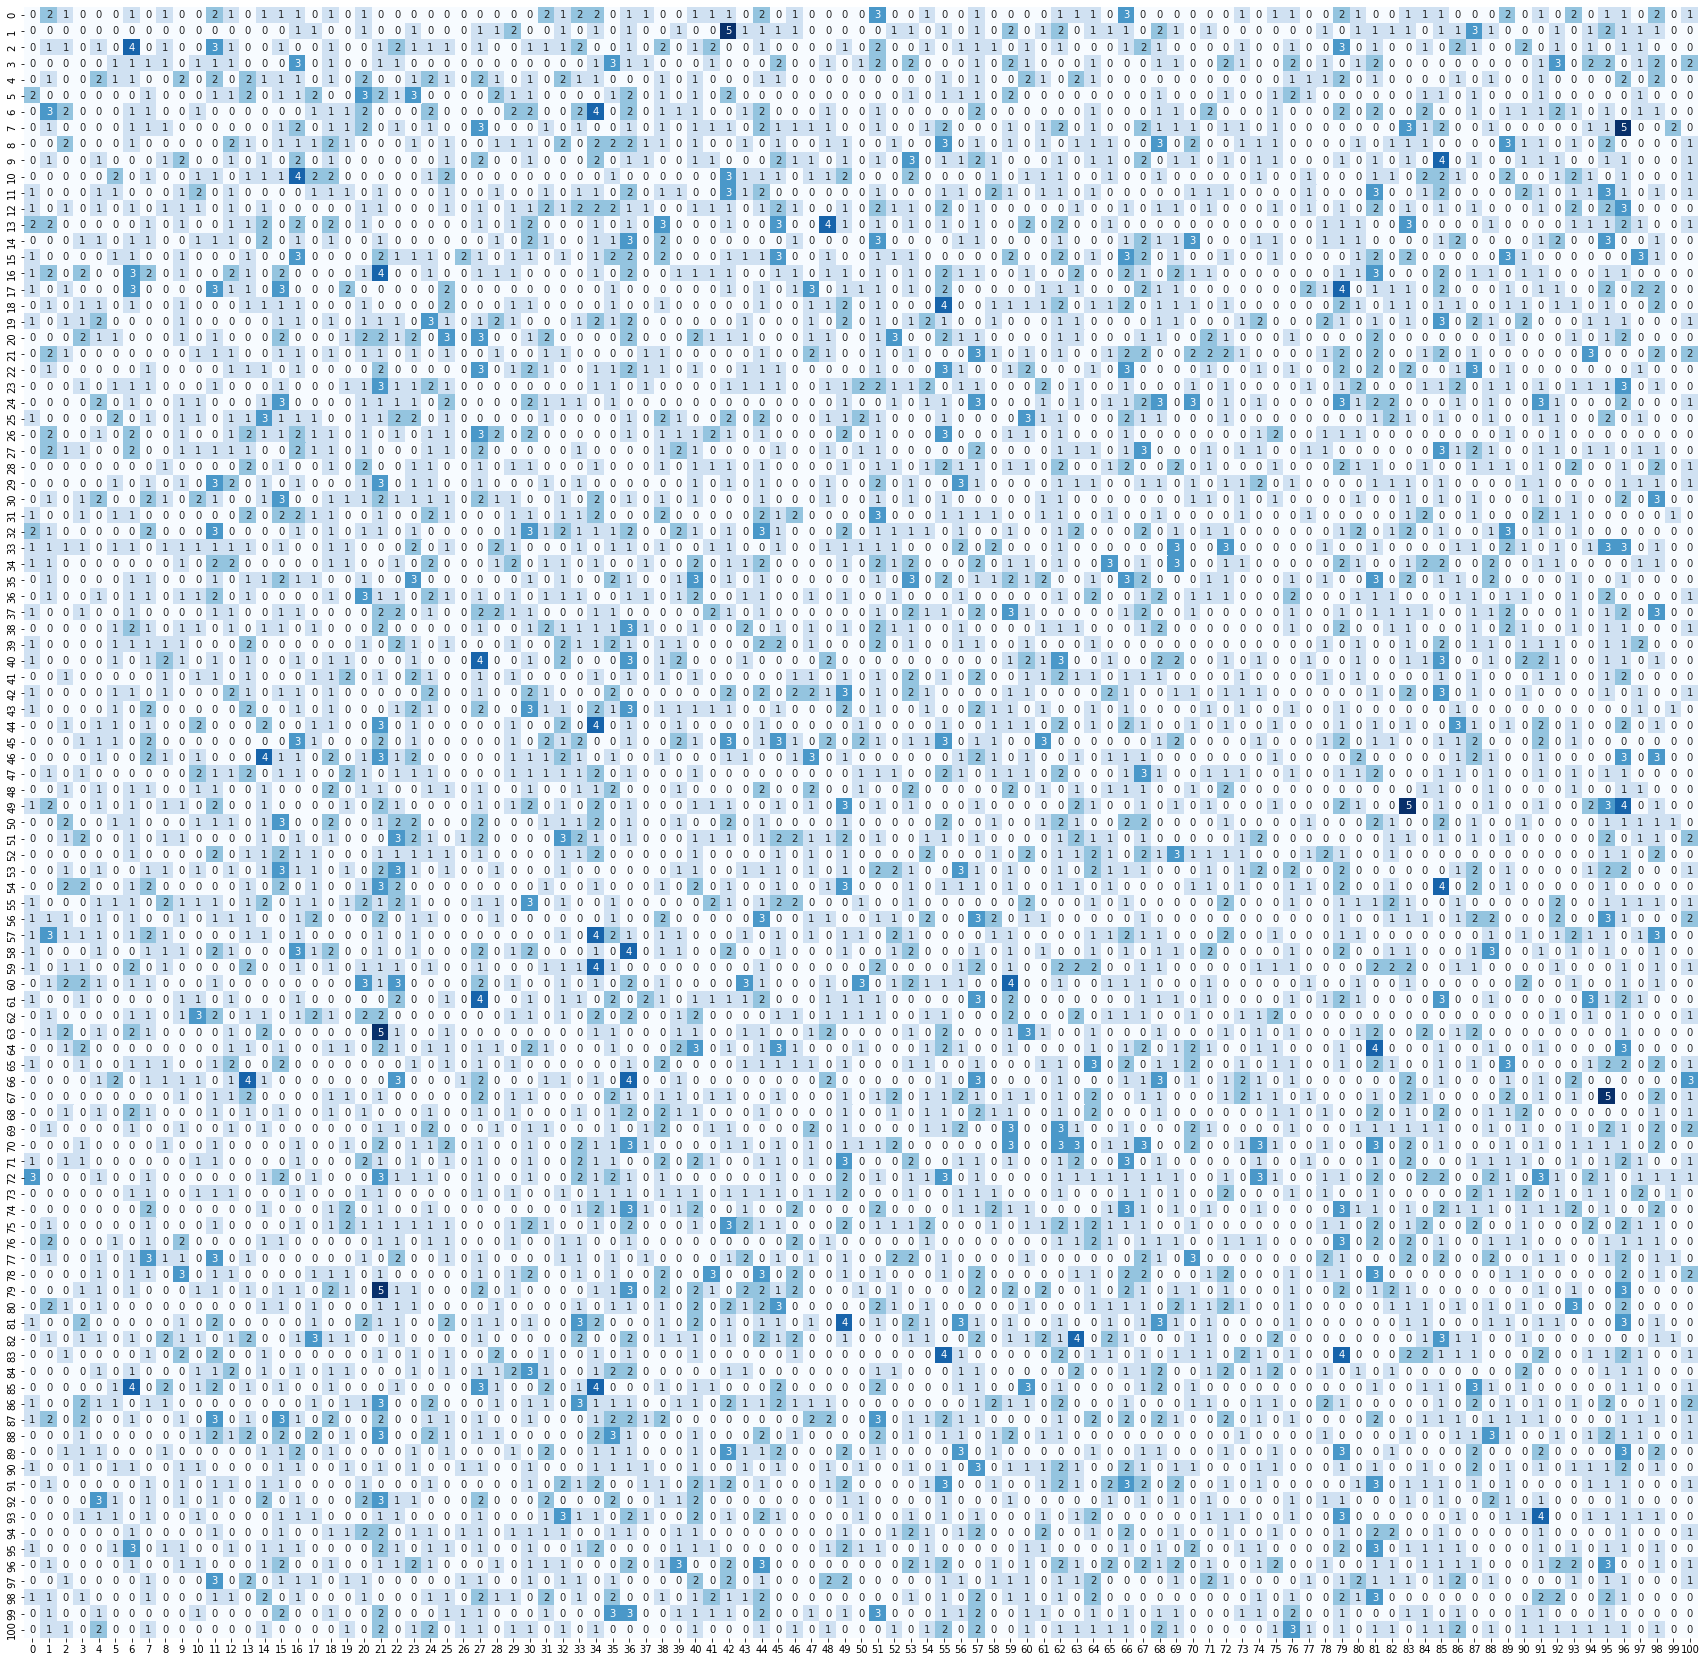

In [32]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, lables=train_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, lables=train_images.class_indices, rotation=0)
plt.xlable("Predicted")
plt.ylable("Actual")
plt.title("Confusion Matrix")
plt.show()